<a href="https://colab.research.google.com/github/sofialctv/ai-ifes/blob/main/PYTORCH_LAB7_Classificacao_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Dígitos com PyTorch usando o Dataset MNIST

Este notebook guiará o aluno por todas as etapas necessárias para construir, treinar e avaliar uma rede neural simples para classificar dígitos escritos à mão usando o dataset MNIST.

## Importações

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Download e Preparação dos Dados (MNIST)

O dataset MNIST contém imagens de dígitos (0 a 9) escritas à mão. Cada imagem tem tamanho 28x28 pixels, em tons de cinza. Aplicamos transformações para converter e normalizar os dados.

In [ ]:
# Etapa 1: Carregar temporariamente o dataset SEM normalização
temp_transform = transforms.Compose([transforms.ToTensor()])
temp_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)

# Etapa 2: Calcular média e desvio padrão
data_iter = iter(temp_loader)
images, _ = next(data_iter)  # pega todas as imagens
mean = images.mean().item()
std = images.std().item()

print(f"Média calculada: {mean:.4f}, Desvio padrão: {std:.4f}")

Média calculada: 0.1307, Desvio padrão: 0.3081


In [ ]:
# Etapa 3: Definir a transformação com os valores calculados
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
    transforms.Normalize((mean,), (std,))
])

# Etapa 4: Recarregar os datasets com a normalização aplicada
train_dataset = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

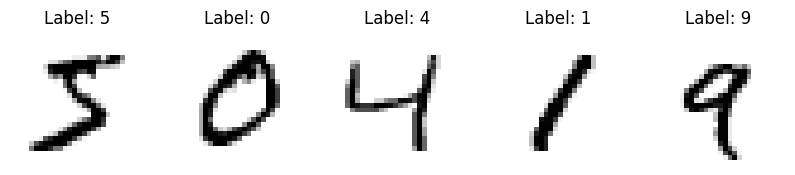

In [ ]:
# visualizar as 5 primeiras imagens (e rótulos) do train_dataset

import matplotlib.pyplot as plt

# Obter as 5 primeiras imagens e rótulos do conjunto de treinamento
images, labels = next(iter(DataLoader(train_dataset, batch_size=5)))

# Criar uma figura com subplots para exibir as imagens
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

# Iterar pelas imagens e rótulos
for i in range(5):
    # Converter a imagem de tensor para uma matriz NumPy
    image = images[i].numpy().squeeze()

    # Exibir a imagem no subplot correspondente
    axes[i].imshow(image, cmap='gray_r')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

# Exibir a figura
plt.show()


## 3. Criação dos DataLoaders (Minibatches)

Dividimos os dados em minibatches para treinar a rede neural de forma eficiente.

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

## 4. Definição da Rede Neural

Criamos uma rede simples com uma camada oculta e uma de saída. Usamos a função de ativação ReLU.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128) # altere o codigo para parametrizar o tamanho da entrada
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 5. Função de Custo e Otimizador

Usamos `CrossEntropyLoss` para classificação multiclasse e o otimizador Adam.

In [ ]:
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 6. Funções de Treinamento e Avaliação

Funções para treinar o modelo e avaliá-lo em cada época.

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return total_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return total_loss / len(dataloader), accuracy

## 7. Loop de Treinamento

Treinamos o modelo por várias épocas e acompanhamos as métricas.

In [ ]:
epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Epoch 1/10 | Train Loss: 0.2300, Acc: 93.06% | Test Loss: 0.1296, Acc: 96.04%
Epoch 2/10 | Train Loss: 0.1017, Acc: 96.91% | Test Loss: 0.0882, Acc: 97.15%
Epoch 3/10 | Train Loss: 0.0733, Acc: 97.68% | Test Loss: 0.0957, Acc: 97.27%
Epoch 4/10 | Train Loss: 0.0548, Acc: 98.21% | Test Loss: 0.1044, Acc: 96.83%
Epoch 5/10 | Train Loss: 0.0483, Acc: 98.44% | Test Loss: 0.0814, Acc: 97.67%
Epoch 6/10 | Train Loss: 0.0374, Acc: 98.80% | Test Loss: 0.0766, Acc: 97.81%
Epoch 7/10 | Train Loss: 0.0323, Acc: 98.92% | Test Loss: 0.1169, Acc: 97.02%
Epoch 8/10 | Train Loss: 0.0298, Acc: 98.99% | Test Loss: 0.0866, Acc: 97.90%
Epoch 9/10 | Train Loss: 0.0244, Acc: 99.19% | Test Loss: 0.1035, Acc: 97.42%
Epoch 10/10 | Train Loss: 0.0229, Acc: 99.21% | Test Loss: 0.1020, Acc: 97.71%


## 8. Avaliação Final

Geramos a matriz de confusão para verificar o desempenho por classe.

In [ ]:
all_labels, all_preds

([np.int64(7),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(1),
  np.int64(4),
  np.int64(9),
  np.int64(5),
  np.int64(9),
  np.int64(0),
  np.int64(6),
  np.int64(9),
  np.int64(0),
  np.int64(1),
  np.int64(5),
  np.int64(9),
  np.int64(7),
  np.int64(3),
  np.int64(4),
  np.int64(9),
  np.int64(6),
  np.int64(6),
  np.int64(5),
  np.int64(4),
  np.int64(0),
  np.int64(7),
  np.int64(4),
  np.int64(0),
  np.int64(1),
  np.int64(3),
  np.int64(1),
  np.int64(3),
  np.int64(4),
  np.int64(7),
  np.int64(2),
  np.int64(7),
  np.int64(1),
  np.int64(2),
  np.int64(1),
  np.int64(1),
  np.int64(7),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(5),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(6),
  np.int64(3),
  np.int64(5),
  np.int64(5),
  np.int64(6),
  np.int64(0),
  np.int64(4),
  np.int64(1),
  np.int64(9),
  np.int64(5),
  np.int64(7),
  np.int64(8),
  np.int64(9),
  np.int64(3),
  np.int64(7),
  np.int64(4),
  np.int64

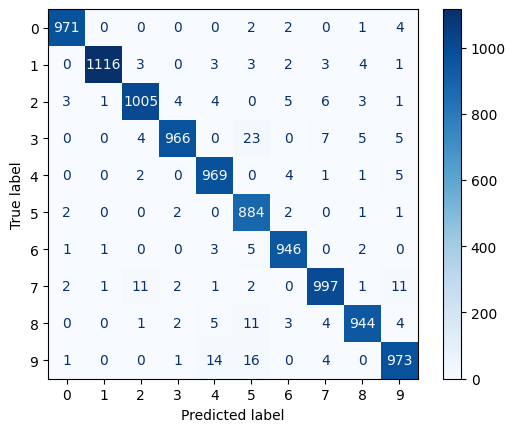

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.show()

## 9. Visualização de Acurácia e Erros

Plotamos a perda e acurácia ao longo das épocas.

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.title('Acurácia por época')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 10. Exercícios (Experimentos)

Sugestões para testarem e aprofundarem o aprendizado:

    1. Mude taxa de aprendizado, batch_size e número de épocas

    2. Troque a função de ativação (ReLU → Tanh, LeakyReLU). Informe qual obteve melhores resultados.

    3. Modifique a arquitetura da rede (mais camadas, mais neurônios)

    4. Aplique dropout entre camadas para reduzir overfitting.

    5. Treine com e sem normalização para comparar os resultados.

    6. Salve e recarregue o modelo com `torch.save` e `torch.load`

    7. Opcional: Teste outro otimizador como SGD com momentum
